In [2]:
# Setup the environment
import numpy as np
import matplotlib.pyplot as plt
import nengo
from nengo.processes import WhiteSignal

In [9]:
# Create the network object to which we can add ensembles, connections, etc.
model = nengo.Network(label="Learning", seed=7)
with model:
    # Ensembles to represent populations
    pre = nengo.Ensemble(50, dimensions=1, label="Pre")
    post = nengo.Ensemble(50, dimensions=1, label="Post")

    # Ensemble to compute the learning error signal
    error = nengo.Ensemble(100, dimensions=1, label="Learning Error")

    # Node to compute the actual error value
    actual_error = nengo.Node(size_in=1, label="Actual Error")

    # Learn the communication channel
    nengo.Connection(pre, actual_error, transform=-1)
    nengo.Connection(pre, error, transform=-1, synapse=0.02)

    # Error = pre - post
    nengo.Connection(post, actual_error, transform=1)
    nengo.Connection(post, error, transform=1, synapse=0.02)

    # Connecting pre population to post population (communication channel)
    conn = nengo.Connection(
        pre,
        post,
        function=lambda x: np.random.random(1),
        solver=nengo.solvers.LstsqL2(weights=True),
    )

    # Adding the learning rule to the connection
    conn.learning_rule_type = {
        "my_pes": nengo.PES(),
        "my_bcm": nengo.BCM(learning_rate=1e-10),
    }

    # Error connections don't impart current
    error_conn = nengo.Connection(error, conn.learning_rule["my_pes"])

    # Providing input to the model
    stim = nengo.Node(WhiteSignal(30, high=10), label="Input")  # RMS = 0.5 by default
    nengo.Connection(stim, pre, synapse=0.02)  # Connect the input to the pre ensemble

    # Function to inhibit the error population after 15s
    def inhib(t):
        return 2.0 if t > 15.0 else 0.0

    # Connecting inhibit population to error population
    inhibit = nengo.Node(inhib, label="Inhibit")
    nengo.Connection(
        inhibit, error.neurons, transform=[[-3]] * error.n_neurons, synapse=0.01
    )

    # Probes
    p_pre = nengo.Probe(pre ,synapse=0.01,label='pre')
    p_pos = nengo.Probe(post,synapse=0.01,label='post')
    p_err = nengo.Probe(error,synapse=0.01,label='error')
    p_ace = nengo.Probe(actual_error,synapse=0.01,label='actual error')

In [12]:
with nengo.Simulator(model) as sim:
    sim.run(20)

/Users/beep/PycharmProjects/nengoPlayground/venv/lib/python3.8/site-packages/nengo/builder/optimizer.py:654: UserWarning: Skipping some optimization steps because SciPy is not installed. Installing SciPy may result in faster simulations.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

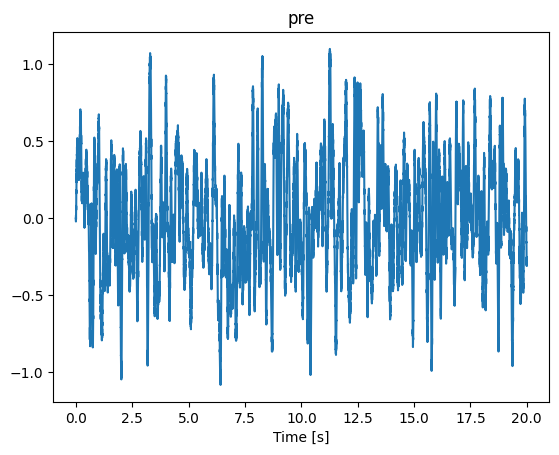

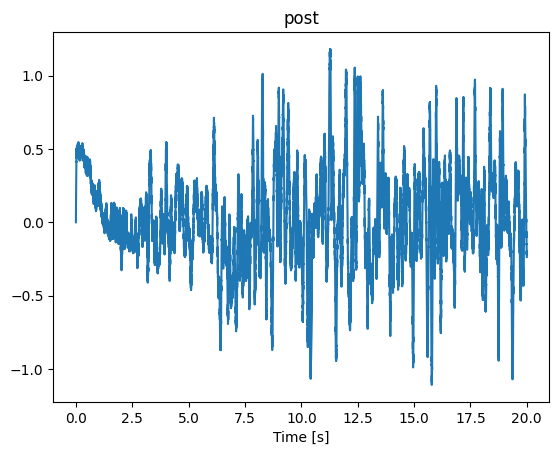

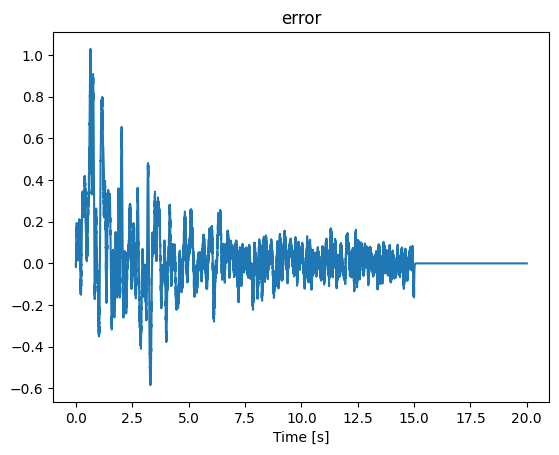

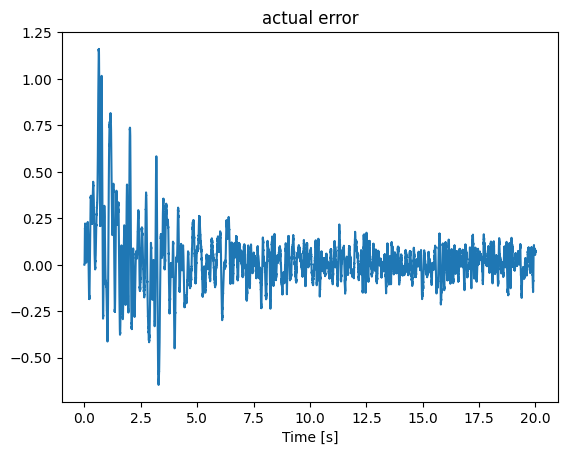

In [13]:
for probe in [p_pre,p_pos,p_err,p_ace]:
    plt.plot(sim.trange(), sim.data[probe])
    plt.xlabel("Time [s]")
    plt.title(probe.label)
    plt.show()